# Full tutorial

This tutorial is similar to the basic tutorial but outlines a more complete workflow. Here, we will use `ARTModel`, a flavor of `InterpolationModel`, to again calculate TiO2's Raman spectrum. `ARTModel` uses "atomic Raman tensors" to predict polarizabilities, but is ultimately an `InterpolationModel` where

1. All degrees of freedom (DOFs) are single atom displacements.
2. All interpolations are first-order.
3. Only two polarizabilities are used to construct each interpolation.

Under these conditions, we dub each DOF polarizability interpolation (or more precisely, the derivative of the interpolation) as an **atomic Raman tensor**, or ART.

Although `ARTModel` dictates that each DOF is a single atom displacement, there are still an infinite number of possible DOFs to choose one. We are free to choose the three directions each atom moves in, so long as they are orthogonal. Ultimately, the choice of atomic DOFs depends on user preference as well as the research question at hand. 

Regardless of how we choose our DOFs, we want to be sure that our DOFs are **valid** before carrying out expensive polarizability calculations and feeding the results into `ARTModel`. To check our DOFs, we use **dummy models**. Essentially, we will build up a polarizability model in the usual way, except we instruct the model to internally generate "dummy polarizabilities". Although a dummy model cannot be used to predict polarizabilities (and therefore cannot be used to compute Raman spectra), it allows us to perform a dry run and make sure all is as it should be.

We'll first import everything we'll need up front, as well as add some customizations for matplotlib.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline

import ramannoodle.io.vasp as vasp_io
from ramannoodle.polarizability.art import ARTModel
from ramannoodle.structure import symmetry_utils
from ramannoodle.spectrum.spectrum_utils import convolve_spectrum
from ramannoodle.structure.displace import write_ast_displaced_structures

matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5

Our final goal is to calculate TiO2's Raman spectrum. As in the basic tutorial, we will start by reading in a reference structure. 

In [2]:
data_dir = "../../../test/data/TiO2"
ref_structure = vasp_io.poscar.read_ref_structure(f"{data_dir}/POSCAR")


Now that we have the reference structure, we can initialize the polarizability model. We do this the usual way, but we specify `is_dummy_model = True`. Because this is a dummy model, the value for `equilibrium_polarizability` is completely ignored. We simply set it to zero. 

In [3]:
model = ARTModel(ref_structure=ref_structure, 
                 equilibrium_polarizability = np.zeros((3,3)), # This value is completely ignored.
                 is_dummy_model=True)               
model

╭──────────────┬──────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions   │ Specified   │   Equivalent atoms │
├──────────────┼──────────────┼─────────────┼────────────────────┤
│            0 │              │ 0/3         │                 35 │
│           36 │              │ 0/3         │                 71 │
╰──────────────┴──────────────┴─────────────┴────────────────────╯
  ATTENTION: this is a dummy model. 

Note that the `__repr__` string indicates that this is a dummy model. In addition, we see that there are two symmetrically distinct atoms: a Ti (at index 0) and an O (at index 36). In this structure, all Ti atoms are equivalent to one another as are all oxygens. Our task is therefore to compute and add DOFs for a single Ti atom and a single O atom. Ramannoodle will use symmetry to derive the remaining DOFs, at which point the model is fully specified. 

For this example, we will choose atomic displacements along the x, y, and z directions as our DOFs. We therefore must first generate structures for these displacements then, outside Raman noodle, calculate the polarizabilities from first principles. To help set up these calculations, ramannoodle provides routines to write displaced structures in `ramannoodle.structure.displace`. Since we're using atomic Raman tensors, we will use `write_ast_displaced_structures`.

In [4]:
# Degrees of freedom (atomic Raman tensor) for one of the Ti atoms
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=4,
    cart_direction=np.array([1,0,0]), # x direction
    amplitudes = np.array([0.1]),     # -0.1 is symmetrically equivalent
    file_paths = ["Ti5_0.1x_eps_POSCAR"],
    file_format='poscar'
)
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=4,
    cart_direction=np.array([0,0,1]), # z direction
    amplitudes = np.array([0.1]),    # -0.1 is symmetrically equivalent
    file_paths = ["Ti5_0.1z_eps_POSCAR"],
    file_format='poscar'
)

# Degrees of freedom (atomic Raman tensor) for one of the O atoms
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=42,
    cart_direction=np.array([1,0,0]), # x direction
    amplitudes = np.array([0.1]),     # -0.1 is symmetrically equivalent
    file_paths = ["O43_0.1x_eps_POSCAR"],
    file_format='poscar'
)
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=42,
    cart_direction=np.array([0,1,0]), # y direction
    amplitudes = np.array([0.1]), # -0.1 is symmetrically equivalent
    file_paths = ["O43_0.1y_eps_POSCAR"],
    file_format='poscar'
)
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=42,
    cart_direction=np.array([0,0,1]), # z direction
    amplitudes = np.array([-0.1,0.1]), # these are unique
    file_paths = ["O43_m0.1z_eps_POSCAR","O43_0.1z_eps_POSCAR"], 
    file_format='poscar'
)

We have wisely chosen our displaced structures based on symmetry and written them to POSCARs. Before calculating polarizabilities with these POSCARs, however, we want to make sure that these displacements **cover all the DOFs of our system**. To do this, we build up our dummy model.

In [5]:
# Now we can add the outcars. Because we have a dummy model, ramannoodle will not look for polarizabilities in these files. Therefore, we could use OUTCARs from other calculations or (more commonly) use POSCARs.
model.add_art_from_files(
    ["Ti5_0.1x_eps_POSCAR"], file_format = 'poscar'
  )
model.add_art_from_files(
    ["Ti5_0.1z_eps_POSCAR"],file_format = 'poscar'
  )
model.add_art_from_files(
    ["O43_0.1z_eps_POSCAR", "O43_m0.1z_eps_POSCAR"], 
    file_format="poscar"
)
model.add_art_from_files(
    ["O43_0.1x_eps_POSCAR"], file_format = 'poscar'
)
model.add_art_from_files(["O43_0.1y_eps_POSCAR"],file_format = 'poscar')
model

╭──────────────┬─────────────────────────────────────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions                                  │ Specified   │   Equivalent atoms │
├──────────────┼─────────────────────────────────────────────┼─────────────┼────────────────────┤
│            0 │ [-1. -0. +0.], [-0. -1. -0.], [-0. -0. +1.] │ 3/3         │                 35 │
│           36 │ [+0. +0. +1.], [+1. +0. +0.], [+0. +1. +0.] │ 3/3         │                 71 │
╰──────────────┴─────────────────────────────────────────────┴─────────────┴────────────────────╯
  ATTENTION: this is a dummy model. 

From the "Specified" column, we see that all degrees of freedom have been specified. Clearly, we chose our DOFs wisely. Nice work! Note that using POSCARs, which contain no polarizability data, to build up dummy polarizability models is possible since dummy polarizabilities are automatically generated. 

Just for kicks, what will happen if we try to compute a Raman spectrum with this dummy model?

In [6]:
# Compute and plot spectrum
phonons = vasp_io.outcar.read_phonons(f"{data_dir}/phonons_OUTCAR")
spectrum = phonons.get_raman_spectrum(model)
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(wavenumbers, total_intensities)

UsageError: dummy model cannot calculate polarizabilities

Since dummy models contain no polarizability information, they cannot be used to compute spectra! 

Now that we're sure our DOFs are valid, we carry out the polarizability calculations using VASP. We can then construct the real model, this time pointing to OUTCARs generated from these polarizability calculations.

In [7]:
_, equilibrium_polarizability = vasp_io.outcar.read_positions_and_polarizability(
   f"{data_dir}/ref_eps_OUTCAR"
)
model = ARTModel(ref_structure=ref_structure, 
                 equilibrium_polarizability = equilibrium_polarizability)               

model.add_art_from_files(
    [f"{data_dir}/Ti5_0.1x_eps_OUTCAR"], file_format = 'outcar'
  )
model.add_art_from_files(
    [f"{data_dir}/Ti5_0.1z_eps_OUTCAR"],file_format = 'outcar'
  )
model.add_art_from_files(
    [f"{data_dir}/O43_0.1z_eps_OUTCAR", f"{data_dir}/O43_m0.1z_eps_OUTCAR"], 
    file_format="outcar"
)
model.add_art_from_files(
    [f"{data_dir}/O43_0.1x_eps_OUTCAR"], file_format = 'outcar'
)
model.add_art_from_files([f"{data_dir}/O43_0.1y_eps_OUTCAR"],file_format = 'outcar')
model

╭──────────────┬─────────────────────────────────────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions                                  │ Specified   │   Equivalent atoms │
├──────────────┼─────────────────────────────────────────────┼─────────────┼────────────────────┤
│            0 │ [-1. -0. +0.], [-0. -1. -0.], [-0. -0. +1.] │ 3/3         │                 35 │
│           36 │ [+0. -0. +1.], [+1. -0. -0.], [+0. +1. -0.] │ 3/3         │                 71 │
╰──────────────┴─────────────────────────────────────────────┴─────────────┴────────────────────╯

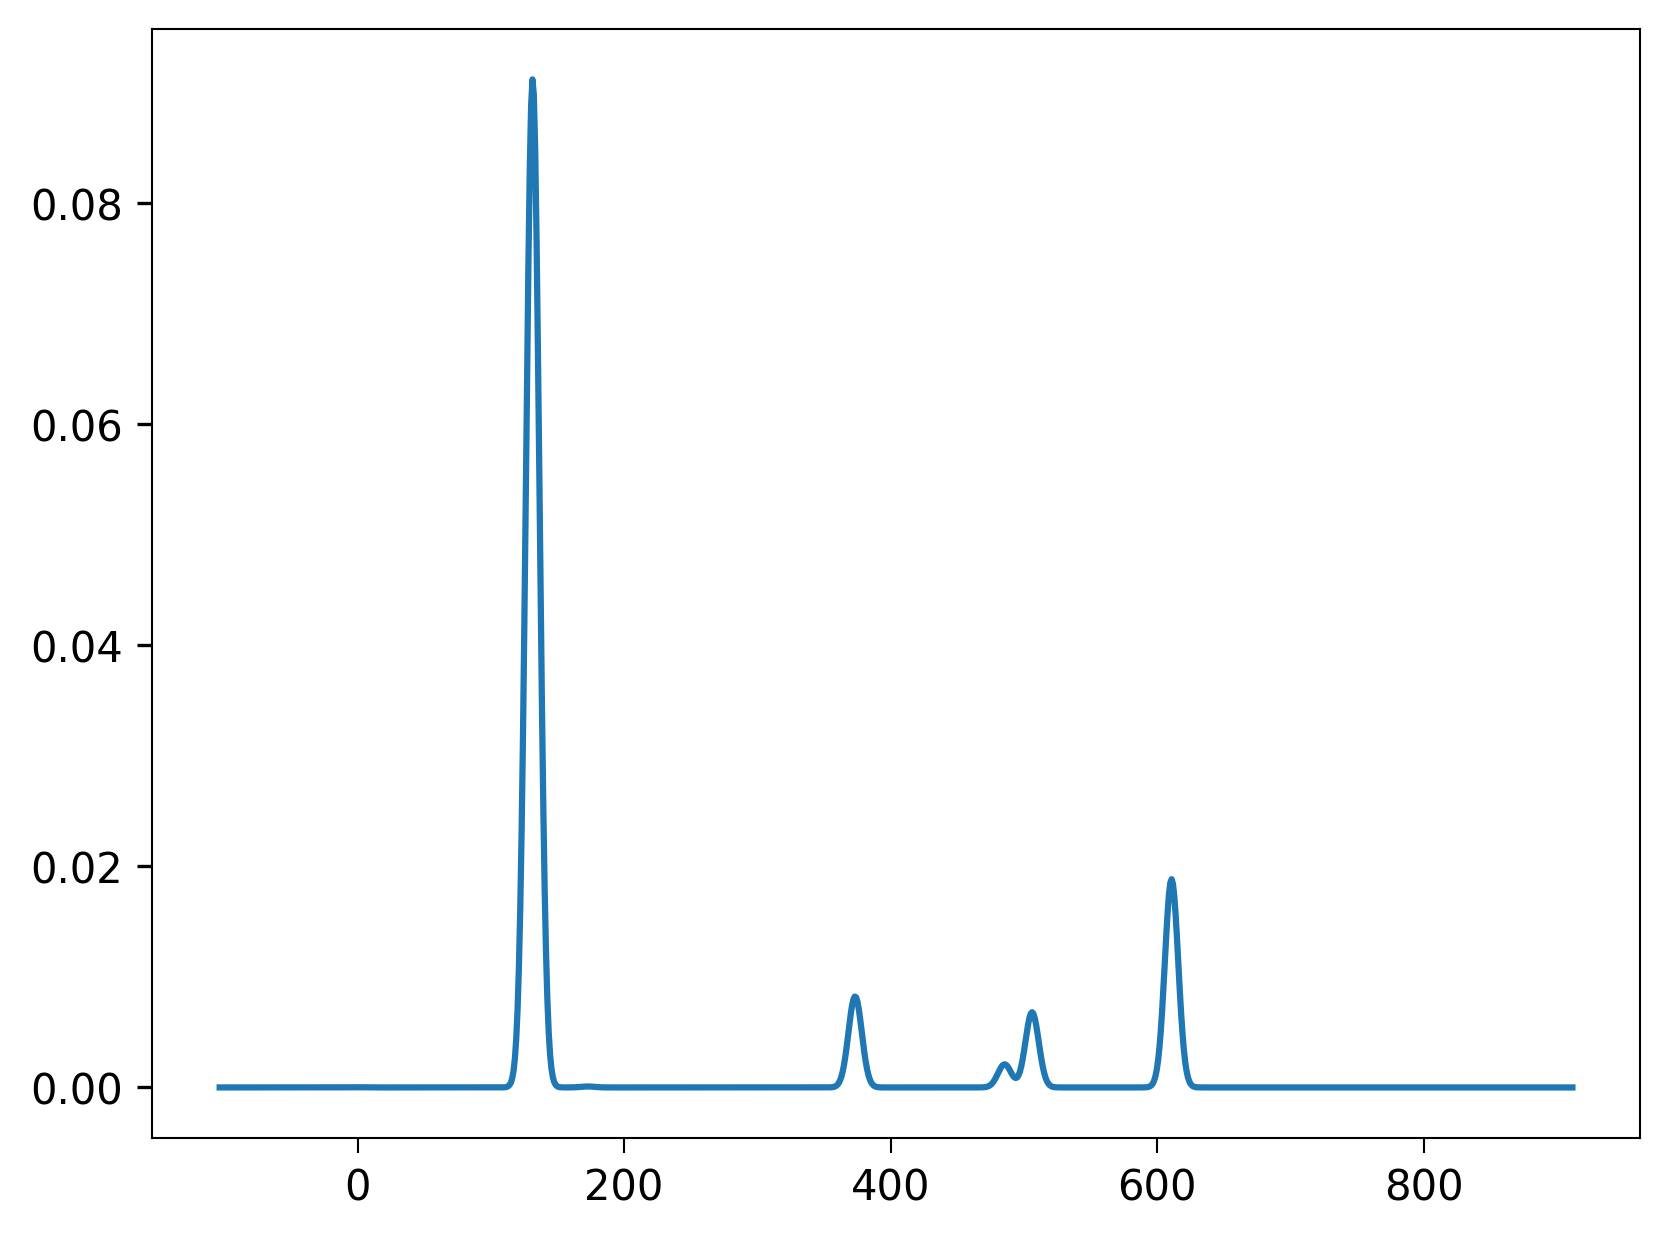

In [8]:
# Compute and plot spectrum
phonons = vasp_io.outcar.read_phonons(f"{data_dir}/phonons_OUTCAR")
spectrum = phonons.get_raman_spectrum(model)
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(wavenumbers, total_intensities)

In conclusion, one can use dummy models to play around with DOFs and make sure that all relevant DOFs are specified before sinking lots of computational time into polarizability calculations.